In [109]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
#from createDataset.params import *
import os
import json
import pandas as pd

import matplotlib.pyplot as plt

In [23]:
LOCAL_PATH = "../Project/data/"
WIKI_DATA = os.path.join(LOCAL_PATH, "wikipedia_male_female.json")

In [100]:
# create the session
spark = SparkSession.builder.getOrCreate()

# create the context
sc = spark.sparkContext

# Load data frame
df = spark.read.json(WIKI_DATA)
df.show()

+--------+---------+--------------------+--------------------+--------------------+--------------------+
|  gender|       id|                name|          occupation|            overview|          wiki-title|
+--------+---------+--------------------+--------------------+--------------------+--------------------+
|Q6581097|Q26998233|       A. E. Pickard|                  []|Albert Ernest Pic...|       A. E. Pickard|
|Q6581097| Q4647941|       A. J. Masters|['Q177220', 'Q753...|Arthur John Masar...|       A. J. Masters|
|Q6581097| Q4648064|A. L. A. Himmelwr...|['Q13582652', 'Q8...|Abraham Lincoln A...|A. L. A. Himmelwr...|
|Q6581097| Q4647256|  A. N. Sattampillai|        ['Q1234713']|Arumai Nayakam Sa...|  A. N. Sattampillai|
|Q6581097|   Q84136|         A. Vellayan|          ['Q43845']|A. Vellayan (born...|         A. Vellayan|
|Q6581097|Q16030065|   A. W. Kjellstrand|        ['Q3246315']|August William Kj...|   A. W. Kjellstrand|
|Q6581097| Q4661199|    Aage Fahrenholtz|       ['Q1133

In [108]:
# Open Gender dictionary
with open('wiki-gender/data/dict_genders.json') as json_file:
    line = json_file.readline()
    dict_genders = json.loads(line)
    
# Open occupations dictionary
dict_occupations = {}
with open('wiki-gender/data/dict_occupations.json') as json_file:
    content = json_file.readlines()
    for line in content:
        occ = json.loads(line)
        dict_occupations.update(occ)
        
# Observation: We need dict_categories_occupations.json in the data folder
# Open occupations categories dictionary
with open('wiki-gender/data/dict_categories_occupations.json') as json_file:
    line = json_file.readline()
    dict_cat_occ = json.loads(line)

# Create function to translate a code into a category
def translate(mapping):
    def translate_(col):
        return mapping.get(col)
    return udf(translate_, StringType())

FileNotFoundError: [Errno 2] No such file or directory: 'wiki-gender/data/dict_categories_occupations.json'

In [101]:
# Translate gender and occupations codes into corresponding labels
df = df.withColumn('gender', translate(dict_genders)('gender'))\
       .withColumn('occupation', explode(split(regexp_replace(regexp_replace(regexp_replace\
                                (regexp_replace(df['occupation'], '\\[', ''), '\\]', ''), ' ', ''),"'", ""), ",")))\
       .filter(col('occupation') != '')\
       .withColumn('occupation', translate(dict_occupations)('occupation'))\
       .withColumn('field', translate(dict_cat_occ)('occupation'))

df.show()

+------+---------+--------------------+--------------------+--------------------+--------------------+
|gender|       id|                name|          occupation|            overview|          wiki-title|
+------+---------+--------------------+--------------------+--------------------+--------------------+
|  male| Q4647941|       A. J. Masters|              singer|Arthur John Masar...|       A. J. Masters|
|  male| Q4647941|       A. J. Masters|          songwriter|Arthur John Masar...|       A. J. Masters|
|  male| Q4648064|A. L. A. Himmelwr...|      civil engineer|Abraham Lincoln A...|A. L. A. Himmelwr...|
|  male| Q4648064|A. L. A. Himmelwr...|            engineer|Abraham Lincoln A...|A. L. A. Himmelwr...|
|  male| Q4647256|  A. N. Sattampillai|          theologian|Arumai Nayakam Sa...|  A. N. Sattampillai|
|  male|   Q84136|         A. Vellayan|      businessperson|A. Vellayan (born...|         A. Vellayan|
|  male|Q16030065|   A. W. Kjellstrand|          head coach|August Willia

In [119]:
# Query to know how many males and females are in the data frame
# Observation: When occupation translation is done, the observations without a label are dropped, that's why, there are less male and female
df.registerTempTable("df")

query = """
SELECT gender, count(DISTINCT id) as Count
FROM df
GROUP BY gender
ORDER BY Count DESC
"""

gender_counts = spark.sql(query)
gender_counts = gender_counts.toPandas()
gender_counts

,gender,Count
0,male,1091472
1,female,218580


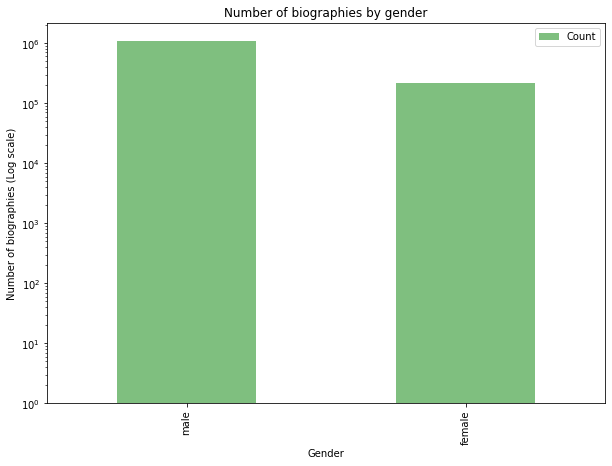

In [120]:
pl = gender_counts.plot(kind="bar", x="gender", y="Count", figsize=(10, 7), log=True, alpha=0.5, color="green")
pl.set_xlabel("Gender")
pl.set_ylabel("Number of biographies (Log scale)")
pl.set_title("Number of biographies by gender");

In [107]:
df.registerTempTable("df")

query = """
SELECT field, count(DISTINCT id) as Count
FROM df
GROUP BY field
ORDER BY Count DESC
"""

occu_cat_counts = spark.sql(query)
occu_cat_counts.toPandas()
occu_cat_counts

+--------------------+---------+
|          occupation|OccuCount|
+--------------------+---------+
|          politician|   190631|
|association footb...|   143450|
|               actor|    75065|
|              writer|    74249|
|                null|    46327|
|          journalist|    40634|
|              singer|    40407|
|          film actor|    36061|
|              lawyer|    36003|
|            composer|    34922|
|             painter|    34871|
|    television actor|    33858|
|  university teacher|    28371|
|American football...|    27984|
|                poet|    27144|
|           cricketer|    26029|
|     baseball player|    24437|
|        screenwriter|    24383|
|      businessperson|    24156|
|  military personnel|    23504|
+--------------------+---------+
only showing top 20 rows



In [121]:
pl = occu_cat_counts.plot(kind="bar", x="field", y="Count", figsize=(10, 7), log=True, alpha=0.5, color="green")
pl.set_xlabel("Occupation Category")
pl.set_ylabel("Number of biographies (Log scale)")
pl.set_title("Number of biographies by ocupations");

NameError: name 'occu_cat_counts' is not defined